In [2]:
from tqdm.notebook import tqdm
from PIL import ImageDraw, ImageOps, ImageFilter
import PIL
PIL.PILLOW_VERSION = PIL.__version__
import os
from shutil import copyfile, rmtree
from IPython.display import Image 

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import random
from shutil import copyfile

import warnings
warnings.simplefilter('ignore')


%matplotlib inline

In [2]:
data_dir = "./locator"

In [3]:
torch.cuda.current_device()

0

In [4]:
colour_enhance = 3

This notebook trains a model that identifies if a 30x30px image of the map contains a hero.

# Validation & Training Sets

Move images from the src directories into the train/validation directories

In [3]:
def colour_filter(img):
    converter = PIL.ImageEnhance.Color(img)
    img = converter.enhance(colour_enhance)
    overlay = PIL.Image.new('RGBA', img.size, (0, 0, 0, 0))
    draw = PIL.ImageDraw.Draw(overlay)
    fill = (255,255,255,128)
    draw.rectangle((0,0,7,30), fill=fill)
    draw.rectangle((0,23,30,30), fill=fill)
    draw.rectangle((23,30,30,0), fill=fill)
    draw.rectangle((30,0,0,7), fill=fill)
    out = PIL.Image.alpha_composite(img, overlay)
    
    return out

def colour_blast(src, dst):
    img = PIL.Image.open(src).convert("RGBA")
    img = colour_filter(img)
    img = img.resize((90,90))
#     plt.imshow(img)
    
    img.save(dst)
    

def empty_dir(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)

In [6]:
# files = os.listdir("./locator/data/blue")
# colour_blast("./locator/data/blue/"+files[0],"")

## Setup Sorted Data

In [7]:
# classes = ["red", "blue", "purple", "terrain"]
classes = ["red", "blue", "terrain"]
dst_all = "./locator/data/final/all/"
data =[]
for c in classes:
    tags = c
    if c == "red" or c == "blue":
        tags = tags + " player"
    
    dst_valid = f"./locator/data/final/valid/{c}/"
    dst_train = f"./locator/data/final/train/{c}/"
    
    for f in os.listdir(dst_train):
        os.remove(dst_train+f)
    for f in os.listdir(dst_valid):
        os.remove(dst_valid+f)
                
    for f in os.listdir(f"./character-icons/split-{c}/"):
        name = "gen-"+c+"-"+f
        colour_blast(f"./character-icons/split-{c}/{f}", dst_all+name)
        data.append((name.replace(".png", ""), tags))
    
    for f in os.listdir(f"./locator/data/{c}/"):
        name = c+"-"+f
        colour_blast(f"./locator/data/{c}/{f}", dst_all+name)
        data.append((name.replace(".png", ""), tags))
        
df = pd.DataFrame(data, columns = ['image_name', 'tags'])
df

,image_name,tags
0,gen-red-4743,red player
1,gen-red-2067,red player
2,gen-red-5138,red player
3,gen-red-6840,red player
4,gen-red-876,red player
...,...,...
28308,terrain-2ca1aa5d-8552-4749-8594-42f1a47e6820,terrain
28309,terrain-95-105-cg_mmm_worlds_2019_0000001174,terrain
28310,terrain-32-28-fnc_rng_1_worlds_oct_13_2019_000...,terrain
28311,terrain-31-37-fnc_rng_1_worlds_oct_13_2019_000...,terrain


# Create Data Batch

Collect the 30x30 images which were split from in-game mini-maps. The model predicts if a player is present in the center 10x10 pixels, the extra image around the center 10x10 gives more context for the model's prediction. 

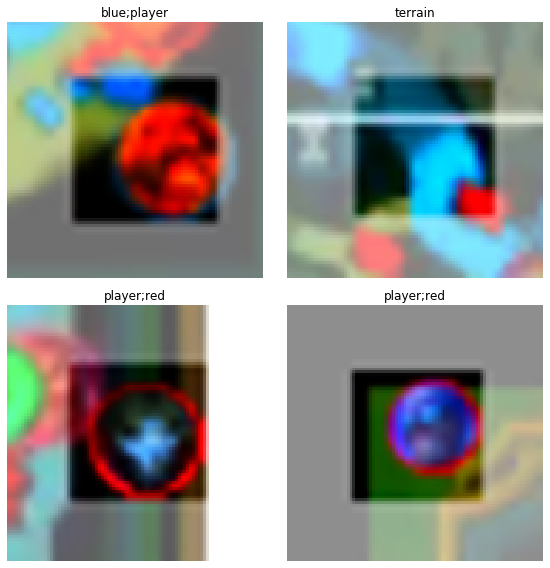

In [9]:
res = []
res.append(rand_zoom(scale=(1.,1.2), p=0.75))
res.append(brightness(change=(0.5*(1-0.4), 0.5*(1+0.4)), p=0.75))
res.append(contrast(scale=(1-0.2, 1/(1-0.2)), p=0.75))
# res.append(cutout(n_holes=(2,10), length=(1, 2), p=1.))

tfms = (res, [])

src = (ImageList.from_df(df, dst_all, suffix=".png", cols=0)
#                 .split_by_idx(range(0,len(df)//5))
                   .split_by_rand_pct(valid_pct=0.2)
                    .label_from_df(label_delim=' ', cols=1))

data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms, size=90, bs=256)

data.show_batch(rows=2)

# Train the Model

We train several models, and keep the one with the highest performance. It is still unknown why some models are better, but one explanation from the fastai course may be the initialization of parameters.

## Model Training

In [10]:
learn = None
gc.collect()

thresh = 0.4
acc_02 = partial(accuracy_thresh, thresh=thresh)
learn = create_cnn(data, models.resnet34, metrics=[acc_02])
learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]

lr = 0.015
learn.fit_one_cycle(1, lr)
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.149677,0.079235,0.970152,00:21


Better model found at epoch 0 with valid_loss value: 0.0792345330119133.


epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.075230,0.087788,0.968430,00:24
1,0.054138,0.053878,0.980572,00:24
2,0.032353,0.051630,0.982559,00:24


Better model found at epoch 0 with valid_loss value: 0.08778751641511917.
Better model found at epoch 1 with valid_loss value: 0.053877923637628555.
Better model found at epoch 2 with valid_loss value: 0.05163005739450455.


## Full Minimap Test

Display the model's predictions for an entire minimap.

In [11]:
grid_size = 15

def draw_grid(draw, labels):
    fill = (255, 255, 255, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        if l[2] == "red":
            fill = (255, 0, 0, 96)
        if l[2] == "blue":
            fill = (0, 0, 255, 96)
        if l[2] == "purple":
            fill = (255, 0, 255, 96)
        draw.rectangle((x-7, y-7, x + 8, y + 8), fill=fill)


def draw_preds(filename, grids):
    img = PIL.Image.open(filename).convert("RGBA")

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, grids)
    out = PIL.Image.alpha_composite(img, overlay)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img);
    ax[1].imshow(out);
#     imshow(np.asarray(out))


def get_predictions(img_dir, learner, predictions):
    # Predict the grid image types
    test = ImageList.from_folder(img_dir)
    learner.data.add_test(test)
    preds = learner.get_preds(ds_type=DatasetType.Test)
    num_preds = len(preds)
    z = 0

    # Identify the grids which are player squares
    for i in range(len(preds[0])):
        p = preds[0][i].tolist()
        pred_map = {}
        for j in range(len(p)):
            pred_map[learn.data.classes[j]] = p[j]
        if pred_map["player"] < pred_map["terrain"] or pred_map["terrain"] > 0.3:
            continue
        if pred_map["red"] < pred_map["terrain"] and pred_map["blue"] < pred_map["terrain"]:
            continue
        if pred_map["red"] > pred_map["blue"]:
            category = "red"
        else:
            category = "blue"
        
        img = test.items[i]
        fname = img.stem
        num = int(fname.split("-")[1])
        name = fname.split("-")[0]
        x = int(round(num//1000))
        y = int(round(num % 1000))
        predictions[name].append((x, y, category))
        
    return predictions


def get_grids(learner, filenames):
    num_files = len(filenames)
    predictions = {}
    # Split the image into grids and save the components to the tmp directory.
    tmp_dir = data_dir+"/tmp"
    empty_dir(tmp_dir)
    numfiles = len(filenames)
    for l in range(numfiles):
        f = filenames[l]
        im = PIL.Image.open(f).convert("RGBA")
        converter = PIL.ImageEnhance.Color(im)
        im = converter.enhance(colour_enhance)
        imgwidth, imgheight = im.size
        base = os.path.basename(f)
        fname = os.path.splitext(base)[0]
        predictions[fname] = []
        for i in range(0, imgheight, grid_size):
            for j in range(0, imgwidth, grid_size):
                box = (j-15, i-15, j + 15, i + 15)
                a = im.crop(box)
                a = colour_filter(a)
                a.save(data_dir+f"/tmp/{fname}-{j*1000//grid_size+i//grid_size}.png")
    
    tmp_dir = data_dir + "/tmp"
    predictions = get_predictions(tmp_dir, learner, predictions)
    empty_dir(tmp_dir)
    return predictions

In [12]:
i = 0

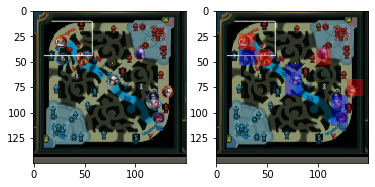

In [62]:
games = os.listdir("./games")
game = random.choice(games)
game_dir = f"./games/{game}/full/"
images = os.listdir(game_dir)
image = random.choice(images)

filenames = [f"games/{game}/full/{image}"]
grids = get_grids(learn, filenames)
base = os.path.basename(filenames[0])
fname = os.path.splitext(base)[0]
draw_preds(filenames[0], grids[fname])

In [63]:
model_path = 'models/'
learn.export(model_path+"locator.pth")

In [64]:
print(learn.data.path)

locator/data/final/all


## Create Full Map Coordinates

Use the model we trained to predict the coordinates of each player in the maps. This csv will be used as the target in the final map prediction model.

In [66]:
# for game in os.listdir("./games"):
#     try:
#         os.remove(f"./games/{game}/full/full_{game}.csv")
#     except FileNotFoundError:
#         print("No Full CSV: " + game)
#     try:
#         os.remove(f"./games/{game}/team/team_{game}.csv")
#     except FileNotFoundError:
#         print("No Team CSV: " + game)

In [69]:
def predict_positions(subdir):
    z = 0
    for game in tqdm(os.listdir("./games")):
        z += 1
        try:
            game_dir = f"./games/{game}/{subdir}"
            maps = os.listdir(game_dir)
        except:
            print(game + "is not a game directory")
            continue
        
        if f"{subdir}_{game}.csv" in maps:
            print(str(z) + game + " positions already detected")
            continue
            
        maps = [m for m in maps if ".png" in m]
        maps = [f"{game_dir}/{m}" for m in maps]
        if len(maps) < 200:
                print(game + "is not a game directory")
                continue
        
        grids = get_grids(learn, maps)

        fnames = []
        tags = []
        for k, v in grids.items():
            v = [f"{g[0]};{g[1]};{g[2]}" for g in v]
            v.sort()
            v = " ".join(v)
            fnames.append(k)
            tags.append(v)

        df = pd.DataFrame({'image_name': fnames, 'tags': tags},
                          columns=['image_name', 'tags'])
        convert_dict = {'image_name': str, 'tags': str}
        df = df.astype(convert_dict)
        df.replace('', np.nan, inplace=True) # Remove the mini-maps with no players.
        df.dropna(subset=['tags'], inplace=True)
        df.to_csv(f"{game_dir}/{subdir}_{game}.csv", index=False)
        print("Finished: " + game)
        
    

In [70]:
predict_positions("full")


1ahq_ig_1_worlds_oct_12_2019 positions already detected


Finished: lcs_2020_jan25_clg_dig
3lec_2020_og_so4 positions already detected
4c9_hka_1_worlds_oct_13_2019 positions already detected
5gam_spy_1_worlds_oct_12_2019 positions already detected


Finished: lec_2020_feb22_sk_vit
7ahq_dwg_1_worlds_oct_13_2019 positions already detected
8ig_tl_1_worlds_oct_12_2019 positions already detected
9c9_grf_1_worlds_oct_15_2019 positions already detected


Finished: lcs_2020_jan25_c9_tl
11lec_2020_mad_vit positions already detected
12g2_hka_1_worlds_oct_18_2019 positions already detected


Finished: lec_2020_feb7_msf_so4


Finished: lec_2020_feb14_rge_so4
15dfm_spy_worlds_2019 positions already detected
16hka_isg_3_2019 positions already detected
17rng_skt_1_worlds_oct_13_2019 positions already detected
18mmm_uol_worlds_2019 positions already detected


Finished: lec_2020_feb14_fnc_vit


Finished: lec_2020_feb8_fnc_og
21lec_2020_g2_vit positions already detected
22grf_hka_1_worlds_oct_18_2019 positions already detected


Finished: lec_2020_feb21_g2_xl


Finished: lec_2020_feb29_g2_vit
25fla_ryl_worlds_2019 positions already detected
26ahq_dwg_1_worlds_oct_20_2019 positions already detected
27fpx_jt_1_worlds_oct_12_2019 positions already detected


Finished: lec_2020_feb14_sk_xl
29hka_isg_1_2019 positions already detected
30lk_mg_2_worlds_2019 positions already detected
31lec_2020_fnc_msf positions already detected
32dwg_ryl_worlds_2019 positions already detected


Finished: lec_2020_feb15_rge_sk
34c9_hka_1_worlds_oct_18_2019 positions already detected


Finished: lec_2020_feb8_vit_xl


Finished: lec_2020_mar7_so4_sk


Finished: lec_2020_feb29_msf_sk


Finished: lec_2020_feb7_og_vit


Finished: lec_2020_feb28_fnc_msf
40hka_lk_2_worlds_2019 positions already detected


Finished: lec_2020_mar6_rge_vit
42lec_2021_g2_mad positions already detected
43ahq_ig_1_worlds_oct_20_2019 positions already detected


Finished: lec_2020_feb7_g2_rge
45lk_mg_worlds_2019 positions already detected
46hka_lk_worlds_2019 positions already detected


Finished: lec_2020_feb8_sacre_s04


Finished: lec_2020_feb7_fnc_xl


Finished: lec_2020_feb28_og_so4
50dwg_tl_1_worlds_oct_20_2019 positions already detected
51cg_skt_1_worlds_oct_19_2019 positions already detected
52lec_2020_mad_xl positions already detected
53fpx_gam_1_worlds_oct_15_2019 positions already detected
54dwg_lk_worlds_2019 positions already detected
55lec_2020_msf_reg positions already detected
56spy_uol_3_2019 positions already detected


Finished: lec_2020_feb28_g2_sk
58jt_spy_1_worlds_oct_15_2019 positions already detected
59lec_2020_g2_sk positions already detected
60ahq_tl_1_worlds_oct_20_2019 positions already detected
61lec_2020_so4_xl positions already detected


Finished: lec_2020_feb29_fnc_so4


Finished: lec_2020_feb1_mad_so4
64spy_uol_2_2019 positions already detected


Finished: lec_2020_feb15_fnc_mad
66spy_uol_6_2019 positions already detected
67cg_ryl_3_worlds_2019 positions already detected


Finished: lec_2020_mar6_mad_so4
69fnc_skt_1_worlds_oct_19_2019 positions already detected
70hka_isg_4_2019 positions already detected
71ig_tl_1_worlds_oct_20_2019 positions already detected


Finished: lec_2020_feb15_og_xl
73g2_grf_2_worlds_oct_18_2019 positions already detected
74cg_fnc_1_worlds_oct_13_2019 positions already detected
75fnc_rng_1_worlds_oct_13_2019 positions already detected
76dwg_fla_worlds_2019 positions already detected


Finished: lec_2020_feb14_g2_msf
78cg_fnc_2_worlds_oct_19_2019 positions already detected


Finished: lec_2020_feb8_mad_rge


Finished: lec_2020_feb21_fnc_rge
81lec_2020_fnc_og positions already detected


Finished: lec_2020_mar7_fnc_g2
83fla_ryl_3_worlds_2019 positions already detected


Finished: lec_2020_mar6_fnc_sk


Finished: lec_2020_feb8_msf_og


Finished: lec_2020_feb15_msf_vit
87fla_ryl_2_worlds_2019 positions already detected
88lec_2020_msf_sk positions already detected


Finished: lec_2020_mar6_g2_og
90jt_spy_1_worlds_oct_17_2019 positions already detected


Finished: lec_2020_feb29_mad_xl


Finished: lec_2020_feb1_rge_vit
93fpx_gam_1_worlds_oct_17_2019 positions already detected
94dwg_lk_4_worlds_2019 positions already detected


Finished: lec_2020_feb1_g2_og
96c9_grf_1_worlds_oct_18_2019 positions already detected
97fpx_spy_1_worlds_oct_17_2019 positions already detected


Finished: lec_2020_feb22_fnc_og
99dwg_tl_1_worlds_oct_12_2019 positions already detected


Finished: lcs_2020_jan25_fly_imt
101cg_ryl_1_worlds_2019 positions already detected


Finished: lec_2020_feb7_mad_sk


Finished: lec_2020_mar7_og_msf
104gam_spy_1_worlds_oct_17_2019 positions already detected


Finished: lcs_2020_jan25_100_gg
106rng_skt_2_worlds_oct_19_2019 positions already detected
107cg_ryl_2_worlds_2019 positions already detected
team_location.csvis not a game directory
109spy_uol_5_2019 positions already detected
110fnc_skt_1_worlds_oct_12_2019 positions already detected


Finished: lec_2020_mar7_vit_xl


Finished: lec_2020_mar6_xl_msf


Finished: lec_2020_feb22_g2_mad
114cg_rng_1_worlds_oct_19_2019 positions already detected


Finished: lec_2020_feb21_og_sk


Finished: lec_2020_feb29_og_rge
117dwg_ig_1_worlds_oct_20_2019 positions already detected
118spy_fpx_1_worlds_oct_17_2019 positions already detected


Finished: lec_2020_feb14_og_mad
120cg_mmm_worlds_2019 positions already detected
121hka_isg_2_2019 positions already detected
122hka_mg_worlds_2019 positions already detected


Finished: lec_2020_mar7_mad_rge
124dwg_lk_3_worlds_2019 positions already detected
125cg_skt_1_worlds_oct_15_2019 positions already detected


Finished: lec_2020_feb28_rge_xl
127spy_uol_4_2019 positions already detected
128dwg_lk_2_worlds_2019 positions already detected
129isg_spy_worlds_2019 positions already detected
130gam_jt_1_worlds_oct_17_2019 positions already detected
131lec_2020_rge_xl positions already detected


Finished: lcs_2020_jan26_dig_eg
133fpx_jt_1_worlds_oct_17_2019 positions already detected
134grf_g2_1_worlds_oct_13_2019 positions already detected


Finished: lec_2020_feb1_fnc_sk


Finished: lec_2020_feb15_g2_so4
137fnc_rng_1_worlds_oct_19_2019 positions already detected


Finished: lec_2020_feb21_so4_vit


Finished: lec_2020_feb22_msf_rge


Finished: lec_2020_feb28_mad_vit
141g2_grf_1_worlds_oct_18_2019 positions already detected
142c9_g2_1_worlds_oct_18_2019 positions already detected


Finished: lec_2020_feb22_so4_xl


Finished: lec_2020_feb1_msf_xl


Finished: lec_2021_vit_sk
146cg_rng_1_worlds_oct_12_2019 positions already detected
147cg_uol_worlds_2019 positions already detected


Finished: lec_2020_feb21_mad_msf
149lec_2020_og_rge positions already detected



# Create Final Data

Collect the data which will used in the final model training.

## Collect Images 

In [72]:
dst_dir = "./games_collected"
empty_dir(f"{dst_dir}/team")
empty_dir(f"{dst_dir}/full")

games = os.listdir("./games")
# Remove images, csv, and other random files from the move
games = [g for g in games if not "." in g and "_" in g]
for g in tqdm(games):
    team_dir = f"./games/{g}/team"
    full_dir = f"./games/{g}/full"
    team_maps = os.listdir(team_dir)
    team_maps = [m for m in team_maps if ".png" in m]
    team_maps.sort()
    for i in range(len(team_maps)):
        shutil.copy(f"{full_dir}/{team_maps[i]}", f"{dst_dir}/full/{team_maps[i]}")
        shutil.copy(f"{team_dir}/{team_maps[i]}", f"{dst_dir}/team/{team_maps[i]}")

## Enhance Images

In [5]:
empty_dir("./games_enhanced")
image_names = os.listdir("./games_collected/team")
for name in tqdm(image_names):
    if not ".png" in name:
        continue
    img = PIL.Image.open("./games_collected/team/"+name).convert("RGBA")
    converter = PIL.ImageEnhance.Color(img)
    img = converter.enhance(colour_enhance)
    img.save("./games_enhanced/"+name)
    